# Prétraitement des données

## Suppression des éléments indésirables de nos tweets

In [1]:
# Imports nécessaires
import pandas as pd
import numpy as np
import string 
import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from nltk.stem import WordNetLemmatizer

In [2]:
# Lecture et stockage de la base de données
tweet_df = pd.read_pickle('../../raw_data/final4_clean.csv')
tweet_df.head()
new_test_df = pd.read_pickle('../../raw_data/update_age_sex.csv')

In [3]:
y = np.arange(0, tweet_df.shape[0])
tweet_df['index'] = y
tweet_df.set_index('index', inplace=True)

In [4]:
# Remove the undesirable elements in the entire dataframe
def rmurl_df(df, column_name):
    '''
    This function removes all the URLs, the #hashtag and the @user of a column made of strings.
    Be careful to apply it BEFORE all the other preprocessing steps (if not it wont'
    be recognized as a URL)
    '''
    df = df.copy()
    df[column_name] = df[column_name].str.replace('http\S+|www.\S+|@\S+|#\S+', '', case=False)
    return df



In [5]:
# Lowercase the tweet's column
def lower_df(df, column_name):
    '''
    This function lowercases a column made of strings.
    '''
    df = df.copy()
    df[column_name] = df[column_name].str.lower()
    return df

In [6]:
# Remove the numbers in the tweet's column
def rmnumbers_df(df, column_name):
    '''
    This function removes all the digits of a column made of strings.
    '''
    df = df.copy()
    def remove_numbers(text):
        return ''.join(word for word in text if not word.isdigit())
    df[column_name] = df[column_name].apply(remove_numbers)
    return df

In [7]:
# Remove the undesirable punctuations in the tweet's column
def rmpunct_df(df, column_name):
    '''
    This function removes all the punctuations, all the "rt" and remove multiple spaces
    of a column made of strings.
    '''
    punct = string.punctuation
    df = df.copy()
    def replace_punct(text):
        for punctu in punct:
            text = text.replace(punctu, ' ')
        text = text.replace(' rt ','')
        text = " ".join(text.split())
        return text
    df[column_name] = df[column_name].apply(replace_punct)
    return df

In [8]:
# Remove the stopwords in the tweet's column
def rmstopwords_df(df, column_name):
    '''
    This function removes all the stopwords of a column made of strings.
    '''
    df = df.copy()
    stop_words = stopwords.words('english')
    def remove_stopwords(text):
        for word in stop_words:
            text = text.replace(f' {word} ', ' ')
        return text
    df[column_name] = df[column_name].apply(remove_stopwords)
    return df

In [9]:
# Lemmatize a column in a dataset
def lemmatize_df(df, column_name):
    '''
    This function lemmatize the words of a column made of strings.
    '''
    df = df.copy()
    def lemmatize(text):
        lemmatizer = WordNetLemmatizer()
        retour = []
        for word in text:
            retour.append(lemmatizer.lemmatize(word))
        text = ''.join(word for word in retour)
        return text

    df[column_name] = df[column_name].apply(lemmatize)
    return df

In [10]:
# Erase all the words that are 1-letter or 2-letters long
def erase_fewletter_df(df, column_name):
    '''
    One or two letters words are deleted from the dataset.
    '''
    df = df.copy()
    def tester(text):
        text = ' '.join( [w for w in text.split() if len(w)>2] )
        return text

    df[column_name] = df[column_name].apply(tester)
    return df


In [11]:
# Remove the undesirable emojis in the entire dataframe
def rmemojis_df(df):
    '''
    This function removes all the emojis of a column made of strings.
    Be careful to translate in latin alphabet before applying this function : 
    it also removes cyrillic alphabet
    '''
    df = df.copy()
    df = df.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))
    return df

In [13]:
clean_df = rmurl_df(new_test_df, 'content')
clean_df = lower_df(clean_df, 'content')
clean_df = rmnumbers_df(clean_df, 'content')
clean_df = rmpunct_df(clean_df, 'content')
clean_df = rmstopwords_df(clean_df, 'content')
clean_df = lemmatize_df(clean_df, 'content')
clean_df = erase_fewletter_df(clean_df, 'content')
clean_df = rmemojis_df(clean_df)

In [14]:
clean_df

,mep_id,name,country,group,nat_group,twitter,content,age,sex
0,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,bardzo dzikuj niezalene wadzy wolne media daj ...,47,1.0
1,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,komisja przyja arcywane projekty pilotaowe aut...,47,1.0
2,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,komisja przyja projekty pilotaowe mojego wspau...,47,1.0
3,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,tym dniu tym miejscu tej godzinie prosz jedno ...,47,1.0
4,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,bg nie potrzebuje by przez nikogo broniony nie...,47,1.0
...,...,...,...,...,...,...,...,...,...
137295,96933,Milan ZVER,Slovenia,Group of the European People's Party (Christia...,Slovenska demokratska stranka,MilanZver,tedenska akcija etrtka srede zbornik bela knji...,63,0.0
137296,96933,Milan ZVER,Slovenia,Group of the European People's Party (Christia...,Slovenska demokratska stranka,MilanZver,strong amp way forward european future read eu...,63,0.0
137297,96933,Milan ZVER,Slovenia,Group of the European People's Party (Christia...,Slovenska demokratska stranka,MilanZver,date noted worrying state danger ends special ...,63,0.0
137298,96933,Milan ZVER,Slovenia,Group of the European People's Party (Christia...,Slovenska demokratska stranka,MilanZver,vsi vedo nekaj noro strahu pred nasilnimi levi...,63,0.0


In [15]:
testbase_df = clean_df[clean_df['country'] == 'Ireland']
testbase_deputy_df = tweet_df[tweet_df['country'] == 'Ireland']

## Création du modèle

### Traitement des données d'entraînement et de test

In [12]:
def embed_sentence(word2vec, sentence):
    y = []
    for word in sentence:
        if word in word2vec.wv.vocab.keys():
           y.append(word2vec[word])
    return np.array(y)

def embedding(word2vec, sentences):
    
    y = []
    for sentence in sentences:
        y.append(embed_sentence(word2vec, sentence))
    return y

In [14]:
# Cette fonction retourne automatiquement X_train, X_test, y_train, y_test de notre base de données twitter.
def get_train_test_objects(df, column):
    '''
    Les étapes que cette fonction réalise sont en commentaires.
    '''
    # Copie de la base de données pour éviter les problèmes d'assignation abusive.
    df = df.copy() 
    # Récupération de tous les tweets et du nom du député qui les a posté. Création de la cible y.
    df = df[['name', 'content']]
    y = pd.get_dummies(df['name'])
    # Transformation des tweets en suite de mots (strings) dans une liste.
    sentences = df['content']
    sentences_inter = []
    for sentence in sentences:
        sentences_inter.append(sentence.split())
    # Séparation des données d'entraînement et de test
    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences_inter, y, test_size = 0.3)
    # Vectorisation des phrases
    word2vec = Word2Vec(sentences=sentences_train)
    # Création des données d'entrée.
    X_train = embedding(word2vec,sentences_train)
    X_test = embedding(word2vec,sentences_test)
    X_train_pad = pad_sequences(X_train, padding='post',value=-1000, dtype='float32')
    X_test_pad = pad_sequences(X_test, padding='post',value=-1000, dtype='float32')
    # Création des données cibles.
    y_train = y_train.values
    y_test = y_test.values
    # Sorties de la fonction
    return X_train_pad, y_train, X_test_pad, y_test, word2vec

In [18]:
X_train, y_train, X_test, y_test, word2vec = get_train_test_objects(testbase_df)

c:\users\psmag\.venvs\delphes\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [19]:
X_train.shape

(2100, 28, 100)

### Initiation du modèle

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def init_model():

    model = Sequential()
    model.add(layers.Masking(mask_value = -1000))
    model.add(layers.LSTM(13, activation='tanh'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
    return model


### Entraînement du modèle et évaluation

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 100, monitor='val_loss', restore_best_weights=True)
model = init_model()
model.fit(X_train, y_train, batch_size = 8, epochs=1000, validation_split = 0.3, callbacks = [es])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 1470 samples, validate on 630 samples
Epoch 1/1000
1470/1470 [==============================] - 8s 6ms/sample - loss: 2.3025 - acc: 0.1061 - val_loss: 2.3024 - val_acc: 0.0889
Epoch 2/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.2993 - acc: 0.1034 - val_loss: 2.2971 - val_acc: 0.0905
Epoch 3/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.2879 - acc: 0.1252 - val_loss: 2.2920 - val_acc: 0.1540
Epoch 4/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.2735 - acc: 0.1381 - val_loss: 2.2675 - val_acc: 0.1238
Epoch 5/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.2617 - acc: 0.1435 - val_loss: 2.2535 - val_acc: 0.1381
Epoch 6/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.2527 -

Epoch 55/1000
1470/1470 [==============================] - 7s 5ms/sample - loss: 2.1492 - acc: 0.2102 - val_loss: 2.2284 - val_acc: 0.1841
Epoch 56/1000
1470/1470 [==============================] - 8s 5ms/sample - loss: 2.1510 - acc: 0.2027 - val_loss: 2.2547 - val_acc: 0.1714
Epoch 57/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.1466 - acc: 0.2163 - val_loss: 2.2573 - val_acc: 0.1841
Epoch 58/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.1480 - acc: 0.2054 - val_loss: 2.2201 - val_acc: 0.1746
Epoch 59/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.1446 - acc: 0.2048 - val_loss: 2.2430 - val_acc: 0.1651
Epoch 60/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.1484 - acc: 0.2014 - val_loss: 2.2225 - val_acc: 0.1810
Epoch 61/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.1407 - acc: 0.2136 - val_loss: 2.2437 - val_acc: 0.1698 loss: 2.1440 - ac
Epoch 62/

Epoch 114/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.0899 - acc: 0.2333 - val_loss: 2.2601 - val_acc: 0.1762
Epoch 115/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.0861 - acc: 0.2395 - val_loss: 2.2712 - val_acc: 0.1778
Epoch 116/1000
1470/1470 [==============================] - 6s 4ms/sample - loss: 2.0879 - acc: 0.2293 - val_loss: 2.3003 - val_acc: 0.1794
Epoch 117/1000
1470/1470 [==============================] - 7s 5ms/sample - loss: 2.0894 - acc: 0.2340 - val_loss: 2.2726 - val_acc: 0.1794
Epoch 118/1000
1470/1470 [==============================] - 8s 5ms/sample - loss: 2.0880 - acc: 0.2333 - val_loss: 2.2890 - val_acc: 0.1873
Epoch 119/1000
1470/1470 [==============================] - 8s 5ms/sample - loss: 2.0847 - acc: 0.2320 - val_loss: 2.2643 - val_acc: 0.1714
Epoch 120/1000
1470/1470 [==============================] - 7s 4ms/sample - loss: 2.0907 - acc: 0.2442 - val_loss: 2.2782 - val_acc: 0.1683
Epoch 121/1000
1470/

In [59]:
model.evaluate(X_test, y_test)

900/900 [==============================] - 0s 122us/sample - loss: 2.2132 - acc: 0.1800


[2.213210598627726, 0.18]

In [21]:
# Renvoie le député le plus proche de votre tweet
def predict_deputy(df, model, tweet, by_tweet = False):
    '''
    La fonction prend la base de données originale (par député), un modèle entraîné et un texte en entrée.
    Elle renvoie le député le plus proche du texte proposé.
    Attention : le texte en entrée doit être une liste d'au moins deux éléments (strings).
    Quand by_tweet = False, on ressort le député le plus proche de l'ENSEMBLE des tweets.
    Quand by_tweet = True, on sort le député le plus proche POUR CHAQUE tweet.
    '''
    tweet_inter = []
    for tw in tweet:
        tweet_inter.append(tw.split())
    X_example = embedding(word2vec,tweet_inter)
    X_example_pad = pad_sequences(X_example, padding='post',value=-1000, dtype='float32')
    prediction = model.predict(X_example_pad)
    if not by_tweet:
        deputy = list(df['name'])[prediction.sum(axis=0).argmax()]
        return deputy
    else:
        deputies_by_tweet = []
        for element in prediction:
            deputies_by_tweet.append(list(df['name'])[element.argmax()])
        return deputies_by_tweet

In [61]:
prediction = predict_deputy(testbase_deputy_df,
                            model, 
                            ['the northern ireland protocol must protected line real effort must made earnest week bridge gap talks come table many times good faith amp view securing future partnership respects standards union', 
                             'member special committee beating cancer look forward working members contributing important fight cancer',
                             'this month shining light childrens cancer parliament buildings lit gold highlight survivors childrens cancer well diagnosed cancer'], 
                            by_tweet=False)

c:\users\psmag\.venvs\delphes\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [62]:
prediction

'Luke Ming FLANAGAN'

In [63]:
testbase_df['content'][24724]

'this month shining light childrens cancer parliament buildings lit gold highlight survivors childrens cancer well diagnosed cancer'

In [64]:
testbase_df

,mep_id,name,country,group,nat_group,twitter,content
24722,124988,Deirdre CLUNE,Ireland,Group of the European People's Party (Christia...,Fine Gael Party,deirdreclunemep,the northern ireland protocol must protected l...
24723,124988,Deirdre CLUNE,Ireland,Group of the European People's Party (Christia...,Fine Gael Party,deirdreclunemep,member special committee beating cancer look f...
24724,124988,Deirdre CLUNE,Ireland,Group of the European People's Party (Christia...,Fine Gael Party,deirdreclunemep,this month shining light childrens cancer parl...
24725,124988,Deirdre CLUNE,Ireland,Group of the European People's Party (Christia...,Fine Gael Party,deirdreclunemep,yesterday told europe need keep speed amp infr...
24726,124988,Deirdre CLUNE,Ireland,Group of the European People's Party (Christia...,Fine Gael Party,deirdreclunemep,this letter sent taoiseach clear seeking clari...
...,...,...,...,...,...,...,...
130490,197863,Maria WALSH,Ireland,Group of the European People's Party (Christia...,Fine Gael Party,mariawalsheu,brendan its favourite item desk
130491,197863,Maria WALSH,Ireland,Group of the European People's Party (Christia...,Fine Gael Party,mariawalsheu,monday mornings mean tidy desk chaos ahead wee...
130492,197863,Maria WALSH,Ireland,Group of the European People's Party (Christia...,Fine Gael Party,mariawalsheu,fergal post kick new week thank folks like mak...
130493,197863,Maria WALSH,Ireland,Group of the European People's Party (Christia...,Fine Gael Party,mariawalsheu,it took rare vision unique leadership see beyo...


# Bac à sable

In [104]:
danish_df = pd.read_pickle('../../delphes/data/six_merged')
#inter_df = pd.merge(danish_df, clean_df.reset_index()[['index','age', 'sex']], on='index')

In [106]:
danish_df

,index,mep_id,name,country,group,nat_group,twitter,content,age,sex,content_y
0,836,125045,Clara AGUILERA,Spain,Group of the Progressive Alliance of Socialist...,Partido Socialista Obrero Español,ClaraAguilera7,"Clara Aguilera: ""El criterio científico debe p...",56,1.0,"[[0.0403111, 0.0812186, -0.0355939, 0.0331782,..."
1,837,125045,Clara AGUILERA,Spain,Group of the Progressive Alliance of Socialist...,Partido Socialista Obrero Español,ClaraAguilera7,🇪🇺🎊🎊🎊as @EUfoodforum we are super proud that o...,56,1.0,"[[-0.0436824, -0.0149531, -0.0435268, 0.025988..."
2,838,125045,Clara AGUILERA,Spain,Group of the Progressive Alliance of Socialist...,Partido Socialista Obrero Español,ClaraAguilera7,"Clara Aguilera: ""El criterio científico debe p...",56,1.0,"[[0.0403111, 0.0812186, -0.0355939, 0.0331782,..."
3,839,125045,Clara AGUILERA,Spain,Group of the Progressive Alliance of Socialist...,Partido Socialista Obrero Español,ClaraAguilera7,"🗣️ @ClaraAguilera7: ""El criterio científico de...",56,1.0,"[False, [-0.0675644, 0.0040941, -0.0185521, 0...."
4,840,125045,Clara AGUILERA,Spain,Group of the Progressive Alliance of Socialist...,Partido Socialista Obrero Español,ClaraAguilera7,Última hora: Bélgica sitúa a toda España en ro...,56,1.0,"[False, [0.0225546, 0.0994218, -0.0251348, -0...."
...,...,...,...,...,...,...,...,...,...,...,...
37387,136695,124739,Carlos ZORRINHO,Portugal,Group of the Progressive Alliance of Socialist...,Partido Socialista,czorrinho,Dia 12.05.2020\n18h\n9Temas 9Debates 9Deputad@...,40,0.0,"[False, False, False, False, False, False, Fal..."
37388,136696,124739,Carlos ZORRINHO,Portugal,Group of the Progressive Alliance of Socialist...,Partido Socialista,czorrinho,Uma entrevista notável ... recomendo. https://...,40,0.0,"[[-0.0529539, 0.00473264, -0.00307722, 0.00865..."
37389,136697,124739,Carlos ZORRINHO,Portugal,Group of the Progressive Alliance of Socialist...,Partido Socialista,czorrinho,Comemorar a Europa dos Valores https://t.co/dz...,40,0.0,"[[-0.0290561, 0.00908396, 0.0969392, 0.0101425..."
37390,136698,124739,Carlos ZORRINHO,Portugal,Group of the Progressive Alliance of Socialist...,Partido Socialista,czorrinho,#EuropeDay2020 #TheProgressives\n@PedroMarques...,40,0.0,[False]


In [133]:
working_df = danish_df[['sex','content_y']].dropna().reset_index()

In [134]:
working_df

,index,sex,content_y
0,0,1.0,"[[0.0403111, 0.0812186, -0.0355939, 0.0331782,..."
1,1,1.0,"[[-0.0436824, -0.0149531, -0.0435268, 0.025988..."
2,2,1.0,"[[0.0403111, 0.0812186, -0.0355939, 0.0331782,..."
3,3,1.0,"[False, [-0.0675644, 0.0040941, -0.0185521, 0...."
4,4,1.0,"[False, [0.0225546, 0.0994218, -0.0251348, -0...."
...,...,...,...
37154,37387,0.0,"[False, False, False, False, False, False, Fal..."
37155,37388,0.0,"[[-0.0529539, 0.00473264, -0.00307722, 0.00865..."
37156,37389,0.0,"[[-0.0290561, 0.00908396, 0.0969392, 0.0101425..."
37157,37390,0.0,[False]


In [135]:
working_df['content_y'].shape[0]

37159

In [136]:
type(working_df['content_y'][0][4])

bool

In [137]:
new_items = [x if type(x) == np.ndarray else np.array([-1000]*100) for x in working_df['content_y'][4]]

In [138]:
new_items

[array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000,
        -1000]),
 array([ 0.0225546 ,  0.0994218 , -0.0251348 , -0.104368  , -0.00467696,
         0.0161251 , -0.0264484 , -0.0260037 ,  0.024174  ,  0.0232939 ,
         0.0372348 , -0.122873  ,  0.0492365 ,  0.023681

In [139]:
for i in range(working_df['content_y'].shape[0]):
    working_df['content_y'][i] = [x if type(x) == np.ndarray else np.array([-1000.5]*300) for x in working_df['content_y'][i]]

c:\users\psmag\.venvs\delphes\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [140]:
working_df = working_df[['sex', 'content_y']]
working_df.rename(columns={"content_y": "content"}, inplace=True)

c:\users\psmag\.venvs\delphes\lib\site-packages\pandas\core\frame.py:4301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [141]:
X = working_df[['content']]

In [142]:
y = working_df['sex']
X_train2, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
# Création des données cibles.
y_train = y_train.values
y_test = y_test.values

In [143]:
def treating_X(X):
    X = X.reset_index().drop('index', axis=1)
    maxi = 0
    for i in range(len(X['content'])):
        if len(X['content'][i]) > maxi:
            maxi = len(X['content'][i])
    c = np.zeros((X.shape[0], maxi, 300))
    i = 0
    for element in X['content']:
        a_len = len(element)
        a = np.array(element)
        c[i][:a_len] = a
        i+=1
    return c

In [144]:
#c = treating_X(X_train2)
c_test = treating_X(X_test)

MemoryError: Unable to allocate 1.45 GiB for an array with shape (11148, 58, 300) and data type float64

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
def init_model():

    model = Sequential()
    model.add(layers.Masking(mask_value = 0))
    model.add(layers.LSTM(100, dropout=0.25, recurrent_dropout=0.25, activation='tanh'))
    model.add(layers.Dense(128, activation='tanh'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
    return model

In [120]:
c.shape

(26011, 58, 300)

In [121]:
y_train

array([0., 1., 0., ..., 0., 1., 0.])

In [122]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 10, monitor='val_loss', restore_best_weights=True)
model = init_model()
model.fit(c, y_train, batch_size = 32, epochs=1000, validation_split = 0.3, callbacks = [es])

Train on 18207 samples, validate on 7804 samples
Epoch 1/1000
18207/18207 [==============================] - 123s 7ms/sample - loss: 0.6905 - acc: 0.5476 - val_loss: 0.6869 - val_acc: 0.5645
Epoch 2/1000
18207/18207 [==============================] - 116s 6ms/sample - loss: 0.6879 - acc: 0.5517 - val_loss: 0.6985 - val_acc: 0.5645
Epoch 3/1000
18207/18207 [==============================] - 113s 6ms/sample - loss: 0.6877 - acc: 0.5551 - val_loss: 0.6858 - val_acc: 0.5645
Epoch 4/1000
18207/18207 [==============================] - 110s 6ms/sample - loss: 0.6871 - acc: 0.5574 - val_loss: 0.6861 - val_acc: 0.5642
Epoch 5/1000
18207/18207 [==============================] - 106s 6ms/sample - loss: 0.6852 - acc: 0.5596 - val_loss: 0.6855 - val_acc: 0.5643
Epoch 6/1000
18207/18207 [==============================] - 106s 6ms/sample - loss: 0.6838 - acc: 0.5585 - val_loss: 0.6899 - val_acc: 0.5639
Epoch 7/1000
11296/18207 [=================>............] - ETA: 32s - loss: 0.6817 - acc: 0.5678

KeyboardInterrupt: 

In [100]:
model.evaluate(c_test, y_test)

11148/11148 [==============================] - 16s 1ms/sample - loss: 0.4793 - acc: 0.8167


[0.47929147977661307, 0.8167384]

### Record à 16.36% avec ce modèle

In [224]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
def init_model():

    model = Sequential()
    model.add(layers.Masking(mask_value = 0))
    model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, activation='tanh'))
    model.add(layers.Dense(128, activation='tanh'))
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
    return model

In [299]:
model_record = model

# Traitement de la base de données finale vectorisée en amont

In [13]:
all_countries = pd.read_hdf('../../raw_data/full_mean_df_hdf.h5', 'h5').dropna()

In [14]:
 age_list = [47, 51, 42, 56, 27, 44, 59, 52, 34, 60, 41, 57, 63,\
           53, 45, 48, 47, 53, 30, 75, 57, 44, 47, 24, 51, 54, 68,\
           49, 42, 50, 49, 40, 34, 34, 38, 44, 37, 54, 56, 61, 83,\
          44, 45, 59, 45, 67, 53, 48, 33, 42, 32, 57, 34, 47, 40, 48,\
          39, 49, 43, 35, 52, 63, 61, 50, 27, 50, 45, 80, 45, 50, 46,\
          59, 41, 47, 65, 51, 44, 34, 68, 37, 31, 57, 35, 37, 65, 57,\
          48, 61, 55, 72, 49, 45, 36, 58, 32, 57, 30, 57, 62, 44, 36, 51,\
          49, 54, 48, 62, 43, 43, 41, 36, 57, 54, 44, 44, 32, 33, 51, 51,\
          51, 56, 56, 43, 41, 43, 61, 63, 44, 36, 49, 49, 54, 42, 55, 53,\
          41, 62, 36, 19, 43, 56, 51, 70, 48, 51, 27, 46, 44, 53, 35, 35,\
          31, 60, 50, 31, 47, 43, 76, 45, 45, 53, 66, 52, 45, 45, 51, 40, 44,\
          48, 56, 56, 65, 27, 48, 39, 55, 35, 44, 40, 43, 52, 31, 50, 53, 58,\
          38, 59, 34, 52, 53, 46, 49, 58, 43, 55, 58, 26, 62, 72, 41, 36, 48,\
          56, 53, 61, 63, 59, 45, 45, 59, 46, 31, 62, 62, 41,\
          67, 44, 40, 62, 40, 49, 53, 61, 60, 38, 68, 54, 57,\
          37, 33, 50, 40, 63, 30, 45, 67, 57, 52, 43, 63, 64,\
          48, 63, 35, 68, 34, 53, 44, 48, 41, 54, 64, 45, 40,\
          41, 55, 61, 42, 46, 68, 36, 69, 47, 71, 55, 42, 52,\
          55, 34, 59, 75, 50, 39, 53, 50, 49, 61, 47, 29, 45,\
          62, 30, 64, 41, 62, 68, 32, 66, 44, 52, 44, 58, 59,\
          47, 58, 34, 66, 39, 70, 54, 41, 64, 43, 65, 74, 38,\
          46, 56, 47, 57, 38, 40, 35, 36, 57, 54, 44, 61, 32,\
          65, 42, 67, 50, 58, 46, 38, 65, 62, 53, 51, 58, 34,\
          29, 22, 53, 39, 59, 57, 61, 36, 55, 41, 71, 40, 49,\
          63, 44, 57, 49, 41, 65, 52, 54, 46, 33, 30, 45, 61,\
          65, 73, 56, 62, 56, 31, 53, 50, 56, 54, 51, 46, 48,\
          72, 59, 47, 60, 46, 72, 37, 59, 45, 53, 51, 48, 66, 67,\
          37, 41, 47, 35, 36, 34, 57, 36, 41, 60, 34, 54, 56, 37,\
          43, 48, 55, 44, 54, 54, 58, 38, 58, 41, 57, 33, 67, 53,\
          57, 41, 41, 48, 62, 38, 66, 46, 42, 70, 62, 54, 53, 75,\
          45, 33, 64, 45, 40, 38, 68, 30, 48, 37, 55, 67, 40, 37,\
          42, 49, 48, 50, 59, 57, 63, 55, 57, 38, 64, 33, 57, 51,\
          63, 48, 37, 52, 56, 57, 58, 57, 34, 34, 46, 57, 34, 60,\
          70, 40, 56, 63, 61, 50, 58]

In [15]:
key_femme = [0, 2, 3, 4, 7, 13, 16, 17, 18 , 19, 24, 29, 30, 31, 34, 35, 43, 45, 47, 49, 53, 55, 59, 61, 62, 64,\
         73, 74, 78, 79, 80, 81, 83, 84, 86, 87, 88, 94, 96, 99, 101, 106, 108, 109, 110, 113, 115, 116, 120, 121, 125, 127, 128, 129, 130,\
        136, 141, 146, 152, 153, 154, 157, 160, 161, 164, 166, 170, 171, 172, 177, 180, 186,\
        187, 188, 191, 195, 197, 198, 201, 205, 206, 208, 209, 210, 211, 213, 214, 216, 219, 220, 222,\
        223, 225, 226, 228, 231, 235, 240, 248, 251, 252, 253, 256, 258, 261, 265, 272, 275, 278, 279, 280,\
        286, 289, 294, 296, 297, 299, 300, 304, 305, 306, 307, 310, 312, 313, 316, 318, 322, 327, 331, 332, 334,\
        337, 338, 340, 343, 343, 344, 349, 351, 352, 355, 356, 360, 361, 363, 365, 367, 374, 376, 379, 381, 383, 384,\
        388, 393, 394, 396, 399, 401, 402, 406, 407, 408, 409, 414, 415, 417, 418, 419, 421, 422, 423, 424, 426, 427,\
        432, 433, 434, 435, 436, 438, 441, 442, 443, 446, 447, 448, 451, 452, 457, 458, 459, 460, 461, 463, 464, 468]


In [16]:
dico = {name:age for name, age in zip(all_countries.name.unique(), age_list)}
for name in dico.keys():
    wonderful_df["age"] = wonderful_df.name.map(dico)

NameError: name 'wonderful_df' is not defined

In [24]:
dico = {name:sex for name, age in zip(all_countries.name.unique(), age_list)}
for name in dico.keys():
    all_countries["sex"] = all_countries.name.map(dico)
real_dict_femme = {key:name for key,name in enumerate(tweet_df.name)}
reel_list_femme = []
for i in key_femme:
    reel_list_femme.append(real_dict_femme[i])
ll = [1] * len(key_femme)
dict_femme = {name:key for name, key in zip(reel_list_femme,ll)}
for name in all_countries['name'].unique():
    if name in dict_femme.keys():
        all_countries["sex"] = all_countries['name'].map(dict_femme)
all_countries['sex'] = all_countries['sex'].fillna(0)

NameError: name 'sex' is not defined

In [25]:
test = np.arange(0,300,1)
herbe = all_countries[test]
y = all_countries['age']


KeyError: 'age'

In [413]:
y

0         47
1         47
2         47
3         47
4         47
          ..
137295    58
137296    58
137297    58
137298    58
137299    58
Name: age, Length: 115656, dtype: int64

In [414]:

X_train3, X_test, y_train, y_test = train_test_split(herbe, y, test_size = 0.3)
# Création des données cibles.
y_train = y_train.values
y_test = y_test.values
X_train3 = np.array(X_train3)
X_test = np.array(X_test)

In [415]:
from tensorflow.keras import backend
backend.clear_session()

In [429]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
def init_model():

    model = Sequential()
    #model.add(layers.GRU(units=27, activation='tanh'))
    #model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2, activation='tanh'))
    model.add(layers.Dense(512, activation='relu'))

    model.compile(loss='mse',
              optimizer='adam', 
              metrics=['mae'])
    return model

In [430]:
X_train3.shape

(80959, 300)

In [422]:
y_train.shape

(80959,)

In [431]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 20, monitor='val_loss', restore_best_weights=True)
model = init_model()
model.fit(X_train3, y_train, batch_size = 32, epochs=1000, validation_split = 0.3, callbacks = [es])

Train on 56671 samples, validate on 24288 samples
Epoch 1/1000
56671/56671 [==============================] - 6s 99us/sample - loss: 1977.8251 - mean_absolute_error: 42.8566 - val_loss: 1462.9929 - val_mean_absolute_error: 36.5133
Epoch 2/1000
56671/56671 [==============================] - 5s 96us/sample - loss: 1086.6392 - mean_absolute_error: 30.7420 - val_loss: 761.5781 - val_mean_absolute_error: 25.0913
Epoch 3/1000
56671/56671 [==============================] - 5s 94us/sample - loss: 540.9730 - mean_absolute_error: 20.2083 - val_loss: 361.2313 - val_mean_absolute_error: 15.7543
Epoch 4/1000
56671/56671 [==============================] - 5s 95us/sample - loss: 260.0430 - mean_absolute_error: 12.9784 - val_loss: 188.9491 - val_mean_absolute_error: 10.9223
Epoch 5/1000
56671/56671 [==============================] - 5s 95us/sample - loss: 162.3263 - mean_absolute_error: 10.1306 - val_loss: 149.0507 - val_mean_absolute_error: 9.7180
Epoch 6/1000
56671/56671 [===========================

Epoch 47/1000
56671/56671 [==============================] - 6s 110us/sample - loss: 123.8635 - mean_absolute_error: 9.0559 - val_loss: 125.2716 - val_mean_absolute_error: 9.0868
Epoch 48/1000
56671/56671 [==============================] - 6s 108us/sample - loss: 123.8394 - mean_absolute_error: 9.0560 - val_loss: 125.2464 - val_mean_absolute_error: 9.0843
Epoch 49/1000
56671/56671 [==============================] - 7s 127us/sample - loss: 123.8155 - mean_absolute_error: 9.0550 - val_loss: 125.2396 - val_mean_absolute_error: 9.0864
Epoch 50/1000
56671/56671 [==============================] - 6s 113us/sample - loss: 123.7936 - mean_absolute_error: 9.0543 - val_loss: 125.2243 - val_mean_absolute_error: 9.0862
Epoch 51/1000
56671/56671 [==============================] - 6s 108us/sample - loss: 123.7682 - mean_absolute_error: 9.0538 - val_loss: 125.2081 - val_mean_absolute_error: 9.0857
Epoch 52/1000
56671/56671 [==============================] - 6s 109us/sample - loss: 123.7500 - mean_abso

Epoch 93/1000
56671/56671 [==============================] - 5s 96us/sample - loss: 123.2855 - mean_absolute_error: 9.0399 - val_loss: 124.8339 - val_mean_absolute_error: 9.0711
Epoch 94/1000
56671/56671 [==============================] - 5s 96us/sample - loss: 123.2737 - mean_absolute_error: 9.0395 - val_loss: 124.8331 - val_mean_absolute_error: 9.0727
Epoch 95/1000
56671/56671 [==============================] - 5s 96us/sample - loss: 123.2696 - mean_absolute_error: 9.0403 - val_loss: 124.8203 - val_mean_absolute_error: 9.0699
Epoch 96/1000
56671/56671 [==============================] - 6s 99us/sample - loss: 123.2613 - mean_absolute_error: 9.0383 - val_loss: 124.8226 - val_mean_absolute_error: 9.0723
Epoch 97/1000
56671/56671 [==============================] - 5s 96us/sample - loss: 123.2510 - mean_absolute_error: 9.0393 - val_loss: 124.8093 - val_mean_absolute_error: 9.0693
Epoch 98/1000
56671/56671 [==============================] - 5s 96us/sample - loss: 123.2457 - mean_absolute_e

KeyboardInterrupt: 

In [432]:
model.evaluate(X_test, y_test)

34697/34697 [==============================] - 1s 35us/sample - loss: 125.2299 - mean_absolute_error: 9.1084


[125.22992701087523, 9.108447]

In [433]:
X_test

array([[-0.0175197 ,  0.00992171, -0.01704188, ...,  0.05187736,
         0.01849563,  0.01764313],
       [-0.03293978, -0.02777258,  0.00764282, ..., -0.00032787,
         0.02070131,  0.00792274],
       [-0.02664617, -0.01571659, -0.00623735, ...,  0.01619654,
         0.02345402,  0.04484541],
       ...,
       [-0.0140244 , -0.01213397, -0.03705579, ...,  0.02204706,
         0.05742015,  0.02219241],
       [-0.02169255, -0.06224019,  0.06070153, ...,  0.02377004,
         0.0277255 ,  0.02276788],
       [-0.01176275,  0.00484191, -0.01935203, ...,  0.0553019 ,
         0.02143506,  0.02002919]])

In [434]:
import matplotlib.pyplot as plt

In [439]:
loss = model.history.history['loss']
acc = model.history.history['mean_absolute_error']
val_loss = model.history.history['val_loss']
val_acc = model.history.history['val_mean_absolute_error']

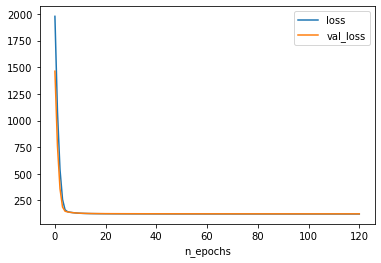

In [440]:
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('n_epochs')
plt.legend()

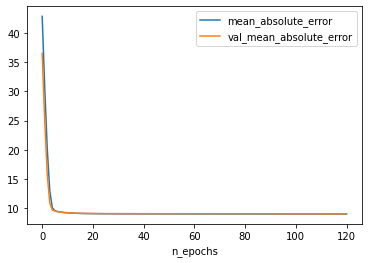

In [442]:
plt.plot(acc, label='mean_absolute_error')
plt.plot(val_acc, label='val_mean_absolute_error')
plt.xlabel('n_epochs')
plt.legend()

In [409]:
herbe.loc[0,:]

0     -0.012661
1      0.002554
2     -0.014151
3      0.012570
4     -0.028476
         ...   
295   -0.049243
296   -0.025033
297    0.058314
298    0.019128
299    0.022892
Name: 0, Length: 300, dtype: float64

In [410]:
# Renvoie le député le plus proche de votre tweet
def predict_tweet(df, model, n_tweet, one_tweet = True):
    '''
    La fonction prend la base de données originale (par député), un modèle entraîné et un numéro de tweet en entrée.
    Elle renvoie le député le plus proche du texte proposé.
    Quand one_tweet = False, on ressort le député le plus proche du tweet.
    Quand one_tweet = True, on sort le député le plus proche du compte twitter.
    '''
    test = np.arange(0,300,1)
    herbe = df[test]
    X_example = herbe.loc[n_tweet,:]
    coucou = np.array(X_example)
    if one_tweet:
        lol = np.reshape(coucou, (1, 300))
    prediction = model.predict(lol)
    if one_tweet:
        deputy = y.columns[prediction.argmax()]
        return deputy


In [315]:
all_countries.loc[85200,:]

mep_id                   197577
name               Gilles BOYER
country                  France
group        Renew Europe Group
nat_group           Indépendant
                    ...        
295                   -0.113138
296                  -0.0324296
297                    0.034569
298                   0.0480666
299                  -0.0243168
Name: 85200, Length: 308, dtype: object

In [411]:
for i in range(85000,85300):
    print(predict_tweet(all_countries.reset_index(), model, i))

AttributeError: 'Series' object has no attribute 'columns'

In [135]:
test = np.arange(0,300,1)
herbe = all_countries.reset_index()[test]
X_example = herbe.loc[1,:]
coucou = np.array(X_example)
model.predict(lol).argmax()

183

In [136]:
all_countries.loc[0:300,:]

mep_id                                                  197490
name                                       Magdalena ADAMOWICZ
country                                                 Poland
group        Group of the European People's Party (Christia...
nat_group                                          Independent
                                   ...                        
295                                                 -0.0492426
296                                                 -0.0250329
297                                                  0.0583143
298                                                  0.0191282
299                                                  0.0228919
Name: 0, Length: 308, dtype: object

In [208]:
import io

In [210]:
languages = ['english']

def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

nmax = 100000  # maximum number of word embeddings to load
emb_dict = {}
for lang in languages:
    path = f"../../raw_data/vectors_{lang}.txt" #Select here
    embeddings, id2word, word2id = load_vec(path, nmax)
    emb_dict[lang] = [embeddings, id2word, word2id]

print("Dict created")


def multilang_word_vector(word, emb_dict, lang):
    try:
        if word in emb_dict.get(lang)[2].keys():
            return emb_dict[lang][0][emb_dict[lang][2][word]]
        return []
    except:
        return []


Dict created


In [337]:
phrase = 'brazil'
phrase = phrase.lower()

In [338]:
sentence = []
for word in phrase.split():
    sentence.append(multilang_word_vector(word, emb_dict, 'english'))
sentence = pd.DataFrame(sentence)
sentence = sentence.mean()
coucou = np.array(sentence)
lol = np.reshape(coucou, (1, 300))

In [339]:
prediction = model.predict(lol)
y.columns[prediction[0].argsort()[-30:][::-1]]

Index(['Clara PONSATÍ OBIOLS', 'Jordi CAÑAS', 'Ibán GARCÍA DEL BLANCO',
       'Jonás FERNÁNDEZ', 'Diana RIBA I GINER', 'Carles PUIGDEMONT I CASAMAJÓ',
       'Esteban GONZÁLEZ PONS', 'Isabel BENJUMEA BENJUMEA',
       'José Ramón BAUZÁ DÍAZ', 'José Manuel GARCÍA-MARGALLO Y MARFIL',
       'Javi LÓPEZ', 'Lina GÁLVEZ MUÑOZ', 'Franc BOGOVIČ',
       'Antoni COMÍN I OLIVERES', 'César LUENA', 'Luis GARICANO', 'Jordi SOLÉ',
       'Domènec RUIZ DEVESA', 'Ernest URTASUN', 'João FERREIRA',
       'Angel DZHAMBAZKI', 'Marco ZANNI', 'Milan ZVER',
       'Inma RODRÍGUEZ-PIÑERO', 'Stanislav POLČÁK', 'Edina TÓTH',
       'Martina DLABAJOVÁ', 'Tiziana BEGHIN', 'Lídia PEREIRA', 'Sira REGO'],
      dtype='object')

In [348]:
new_test_df[new_test_df['name'] == 'Clara PONSATÍ OBIOLS']['content'].str.find('europe')

-1      292
 253      1
 201      1
 181      1
 176      1
 168      1
 92       1
 40       1
 12       1
Name: content, dtype: int64

# Traitement de la base de données finale traduite

## Prétraitement

In [17]:
wonderful_df = pd.read_pickle('../../raw_data/tweets_en.csv')

In [18]:
wonderful_df

,mep_id,name,country,group,nat_group,twitter,content
0,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,thank you very much free media independent of ...
1,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,the commission has adopted major pilot project...
2,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,the commission adopted my co-authored pilot pr...
3,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,"on this day, at this point in this hour, I am ..."
4,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,god does not need to be defended by anyone and...
...,...,...,...,...,...,...,...
134719,197652,Angelika WINZIG,Austria,Group of the European People's Party (Christia...,Österreichische Volkspartei,AngelikaWinzig,italy's budget policy endangers not only italy...
134720,197652,Angelika WINZIG,Austria,Group of the European People's Party (Christia...,Österreichische Volkspartei,AngelikaWinzig,thank you martin for organizing the eu summer ...
134721,197652,Angelika WINZIG,Austria,Group of the European People's Party (Christia...,Österreichische Volkspartei,AngelikaWinzig,tradition amp modern top companies network mee...
134722,197652,Angelika WINZIG,Austria,Group of the European People's Party (Christia...,Österreichische Volkspartei,AngelikaWinzig,Here is my statement on the budget speech by f...


In [19]:
dico = {name:age for name, age in zip(wonderful_df.name.unique(), age_list)}
for name in dico.keys():
    wonderful_df["age"] = wonderful_df.name.map(dico)


In [20]:
real_dict_femme = {key:name for key,name in enumerate(tweet_df.name)}
reel_list_femme = []
for i in key_femme:
    reel_list_femme.append(real_dict_femme[i])
ll = [1] * len(key_femme)
dict_femme = {name:key for name, key in zip(reel_list_femme,ll)}
for name in all_countries['name'].unique():
    if name in dict_femme.keys():
        wonderful_df["sex"] = wonderful_df['name'].map(dict_femme)
wonderful_df['sex'] = wonderful_df['sex'].fillna(0)

In [21]:
wonderful_df.head(2)

,mep_id,name,country,group,nat_group,twitter,content,age,sex
0,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,thank you very much free media independent of ...,47,1.0
1,197490,Magdalena ADAMOWICZ,Poland,Group of the European People's Party (Christia...,Independent,Adamowicz_Magda,the commission has adopted major pilot project...,47,1.0


In [22]:
clean_df = rmurl_df(wonderful_df, 'content')
clean_df = lower_df(clean_df, 'content')
clean_df = rmnumbers_df(clean_df, 'content')
clean_df = rmpunct_df(clean_df, 'content')
clean_df = rmstopwords_df(clean_df, 'content')
clean_df = lemmatize_df(clean_df, 'content')
clean_df = erase_fewletter_df(clean_df, 'content')
clean_df = rmemojis_df(clean_df)

In [23]:
# Cette fonction retourne automatiquement X_train, X_test, y_train, y_test de notre base de données twitter.
def get_train_test_objects(df, column):
    '''
    Les étapes que cette fonction réalise sont en commentaires.
    '''
    # Copie de la base de données pour éviter les problèmes d'assignation abusive.
    df = df.copy() 
    # Récupération de tous les tweets et du nom du député qui les a posté. Création de la cible y.
    df = df[[column, 'content']]
    y = pd.get_dummies(df[column])
    # Transformation des tweets en suite de mots (strings) dans une liste.
    sentences = df['content']
    sentences_inter = []
    for sentence in sentences:
        sentences_inter.append(sentence.split())
    # Séparation des données d'entraînement et de test
    sentences_train, sentences_test, y_train, y_test = train_test_split(sentences_inter, y, test_size = 0.3)
    # Vectorisation des phrases
    word2vec = Word2Vec(sentences=sentences_train)
    # Création des données d'entrée.
    X_train = embedding(word2vec,sentences_train)
    X_test = embedding(word2vec,sentences_test)
    X_train_pad = pad_sequences(X_train, padding='post',value=-1000, dtype='float32')
    X_test_pad = pad_sequences(X_test, padding='post',value=-1000, dtype='float32')
    # Création des données cibles.
    y_train = y_train.values
    y_test = y_test.values
    # Sorties de la fonction
    return X_train_pad, y_train, X_test_pad, y_test, word2vec

In [136]:
X_train, y_train, X_test, y_test, word2vec = get_train_test_objects(clean_df, 'country')

c:\users\psmag\.venvs\delphes\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


## Entraînement et évaluation du modèle

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

def init_model():

    model = Sequential()
    model.add(layers.Masking(mask_value = -1000))
    model.add(layers.LSTM(10, dropout=0.2, recurrent_dropout=0.2, activation='tanh'))
    model.add(layers.Dense(10, activation='tanh'))
    model.add(layers.Dense(27, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
    return model

In [138]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 3, monitor='val_loss', restore_best_weights=True)
model = init_model()
model.fit(X_train, y_train, batch_size = 32, epochs=1000, validation_split = 0.3, callbacks = [es])

Epoch 1/1000
2063/2063 [==============================] - 56s 27ms/step - loss: 2.8362 - accuracy: 0.1622 - val_loss: 2.7149 - val_accuracy: 0.1898
Epoch 2/1000
2063/2063 [==============================] - 57s 28ms/step - loss: 2.7166 - accuracy: 0.1875 - val_loss: 2.6764 - val_accuracy: 0.1988
Epoch 3/1000
2063/2063 [==============================] - 55s 26ms/step - loss: 2.6901 - accuracy: 0.1931 - val_loss: 2.6558 - val_accuracy: 0.2069
Epoch 4/1000
2063/2063 [==============================] - 56s 27ms/step - loss: 2.6729 - accuracy: 0.1990 - val_loss: 2.6386 - val_accuracy: 0.2075
Epoch 5/1000
2063/2063 [==============================] - 52s 25ms/step - loss: 2.6570 - accuracy: 0.2078 - val_loss: 2.6292 - val_accuracy: 0.2171
Epoch 6/1000
2063/2063 [==============================] - 55s 26ms/step - loss: 2.6418 - accuracy: 0.2124 - val_loss: 2.6099 - val_accuracy: 0.2195
Epoch 7/1000
2063/2063 [==============================] - 51s 25ms/step - loss: 2.6282 - accuracy: 0.2135 - val_

KeyboardInterrupt: 

In [139]:
model.evaluate(X_test, y_test)

885/885 [==============================] - 4s 4ms/step - loss: 2.5290 - accuracy: 0.2407


[2.5290210247039795, 0.24073943495750427]

## Score et sauvegarde du modèle

### Députés

In [140]:
def format_input(input1):
    sentences_inter = []
    for sentence in input1:
        sentences_inter.append(sentence.split())
    X_train = embedding(word2vec,sentences_inter)
    formated_input = pad_sequences(X_train, padding='post',value=-1000, dtype='float32')
    return formated_input

In [197]:
pond = np.sqrt(clean_df.groupby('country').count()['content'].values)
result = (1000*np.mean(model.predict(format_input(['netherlands water', 'amsterdam sweden'])), axis=0)/pond).argmax()
pd.get_dummies(clean_df['country']).columns[result]

c:\users\psmag\.venvs\delphes\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


'Netherlands'

In [199]:
word2vec.save('word2vec_country')

In [200]:
model.save('model_country')

INFO:tensorflow:Assets written to: model_country\assets


Score maximal : 5.12%  Baseline : 0.21%

### Groupe européen

In [ ]:
model_group = model

Score maximal : 33.5%
Baseline : 12.5%

### Sexe

In [515]:
model_sex = model

Score maximal : 59.18%

### Age

### Pays

In [ ]:
model.save('model_country')

Score maximal : 25.02%
Baseline : 3.57%

## Prédictions !

In [26]:
from fast_bert.data_cls import BertDataBunch
train = clean_df[['content', 'name']]
train.rename(columns={"content":"text", "name":"label"}, inplace = True)
x_train, x_test = train_test_split(train, test_size = 0.25)
x_train, x_val = train_test_split(x_train, test_size = 0.25)
x_train.to_csv('train.csv')
x_val.to_csv('val.csv')
pd.DataFrame(train['label'].unique()).to_csv('labels.csv')

In [27]:
databunch = BertDataBunch('.', '.',
                          tokenizer='bert-base-uncased',
                          train_file='train.csv',
                          val_file='val.csv',
                          label_file='labels.csv',
                          text_col='text',
                          label_col='label',
                          batch_size_per_gpu=16,
                          max_seq_length=100,
                          multi_gpu=True,
                          multi_label=True,
                          model_type='bert')

In [84]:
from fast_bert.learner_cls import BertLearner
from fast_bert.metrics import accuracy
import logging
import torch

In [88]:
logger = logging.getLogger()
device_cuda = torch.device("cpu")
metrics = [{'name': 'accuracy', 'function': accuracy}]

In [90]:
learner = BertLearner.from_pretrained_model(
						databunch,
						pretrained_path='bert-base-uncased',
						metrics=metrics,
						device=device_cuda,
						logger=logger,
						output_dir='.',
						finetuned_wgts_path=None,
						warmup_steps=500,
						multi_gpu=True,
						is_fp16=True,
						multi_label=True,
						logging_steps=50)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMultiLabelSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMultiLabelSequenceClassification were not 

In [91]:
learner.lr_find(start_lr=1e-5,optimizer_type='lamb')

c:\users\psmag\.venvs\delphes\lib\site-packages\pytorch_lamb\lamb.py:96: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


KeyboardInterrupt: 

In [92]:
learner.fit(epochs=6,
			lr=6e-5,
			validate=True, 	# Evaluate the model after each epoch
			schedule_type="warmup_cosine",
			optimizer_type="adamw")

KeyboardInterrupt: 